In [25]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

# --- TRANSFORMS ---
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- CUSTOM HANDWRITTEN TEST LOADER ---
def ProjectDataLoader(path='./handpicked', transform=None):
    images, labels = [], []
    for filename in os.listdir(path):
        if filename.endswith('.png') and '-' in filename:
            try:
                label = int(filename.split('-')[0])
                img_path = os.path.join(path, filename)
                img = Image.open(img_path).convert('L').resize((28, 28))
                img = transform(img) if transform else transforms.ToTensor()(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Skipping file {filename}: {e}")

    if not images:
        raise RuntimeError("No valid .png images found in the directory.")

    return torch.stack(images), torch.tensor(labels).long()

# --- LOAD TEST SET ---
test_batch, test_labels = ProjectDataLoader('./handpicked', transform=transform_test)
testloader_custom = DataLoader(TensorDataset(test_batch, test_labels), batch_size=1, shuffle=False)

print("Custom handwritten test set loaded successfully.")



Custom handwritten test set loaded successfully.


In [26]:
from torch import nn

model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


In [27]:
import torch
import matplotlib.pyplot as plt
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track metrics
train_loss_history = []
val_acc_history = []

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_loss_history.append(avg_loss)

    # --- Validation on handwritten test set ---
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader_custom:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Handwritten Accuracy: {val_acc:.2f}%")


Epoch 1/10 - Train Loss: 0.5989 - Handwritten Accuracy: 42.77%
Epoch 2/10 - Train Loss: 0.2607 - Handwritten Accuracy: 46.99%
Epoch 3/10 - Train Loss: 0.2055 - Handwritten Accuracy: 46.39%
Epoch 4/10 - Train Loss: 0.1793 - Handwritten Accuracy: 54.82%
Epoch 5/10 - Train Loss: 0.1587 - Handwritten Accuracy: 53.01%
Epoch 6/10 - Train Loss: 0.1477 - Handwritten Accuracy: 51.81%
Epoch 7/10 - Train Loss: 0.1380 - Handwritten Accuracy: 54.82%
Epoch 8/10 - Train Loss: 0.1290 - Handwritten Accuracy: 48.80%
Epoch 9/10 - Train Loss: 0.1230 - Handwritten Accuracy: 54.82%
Epoch 10/10 - Train Loss: 0.1147 - Handwritten Accuracy: 58.43%


In [28]:
# --- 7. Evaluation Function ---

def evaluate_model(model, dataloader, description="Test Set"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\nAccuracy on {description}: {accuracy:.2f}%")

evaluate_model(model, testloader_custom, "Custom Handwritten Digits")




Accuracy on Custom Handwritten Digits: 58.43%


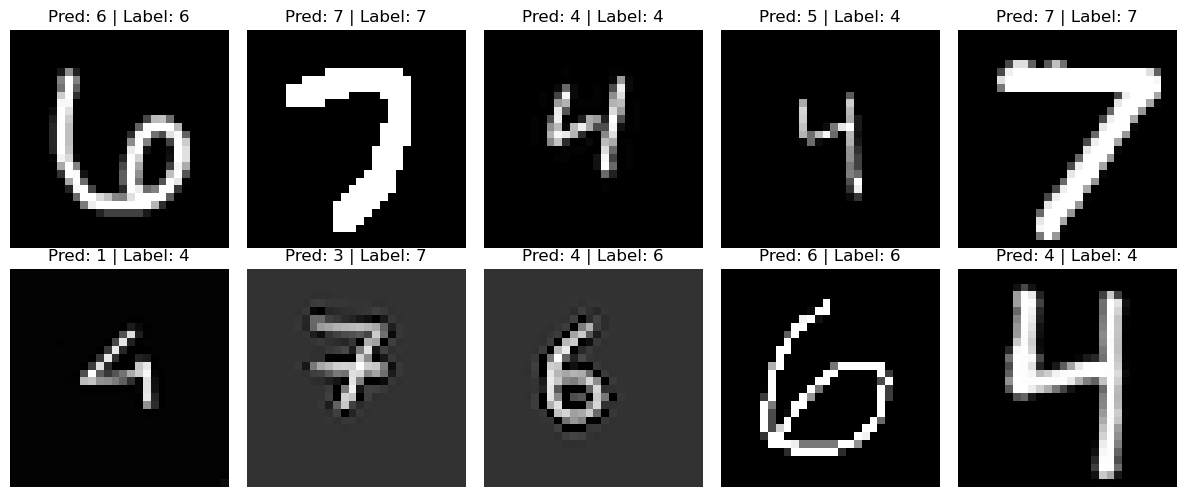

In [29]:
def show_mnist_predictions(model, testloader, num_images=10):
    model.eval()

    # Collect enough images for the grid
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images.to(next(model.parameters()).device))
            _, preds = torch.max(outputs, 1)

            images_list.extend(images.cpu())
            labels_list.extend(labels.cpu())
            preds_list.extend(preds.cpu())

            if len(images_list) >= num_images:
                break

    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axs.flat):
        img = images_list[i][0]  # [C, H, W] → [H, W]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {preds_list[i].item()} | Label: {labels_list[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on custom handwritten digits
show_mnist_predictions(model, testloader_custom)


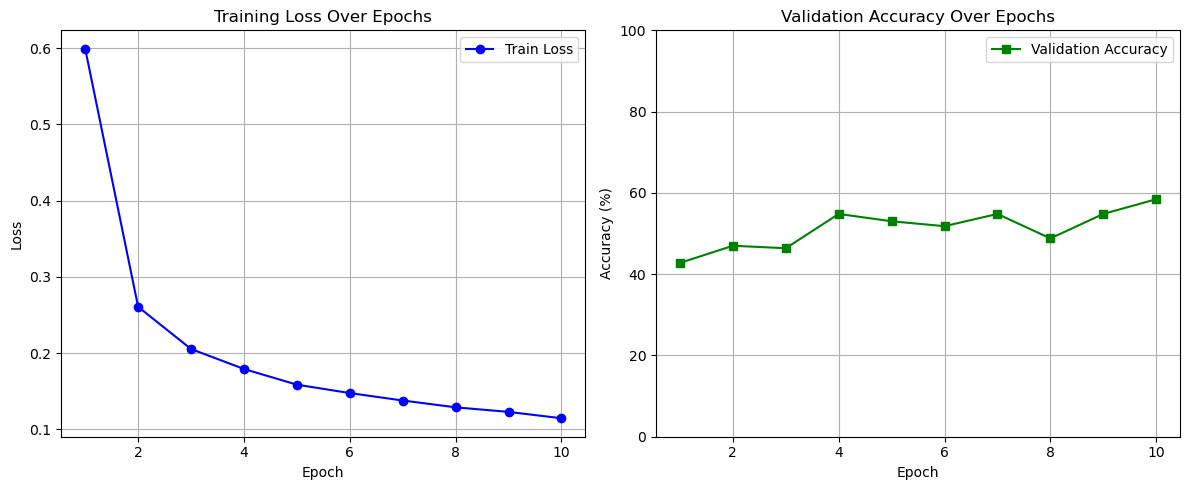

In [30]:
plt.figure(figsize=(12, 5))

# --- Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, marker='o', label='Train Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# --- Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_acc_history, marker='s', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
